In [ ]:
import sys
sys.path.insert(0, '../Utilities')

import numpy as np
from itertools import combinations
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx
from networkx.algorithms import bipartite

import hypergraphx as hx
from hypergraphx.core.hypergraph import Hypergraph
from hypergraphx.representations.projections import bipartite_projection

from utilities_fibration import *
from trajectories_kuramoto_hoi import *
from find_sync_clusters_from_trajectories import *


import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # use serif font
    "text.latex.preamble": r"\usepackage{lmodern}",  # match LaTeX document font
})


In [3]:
# Define hypergraph
edge_list_sc_filtered_hpg = [[0,1,2],[0,6],[6,3],[3,4],[4,5],[5,3],[6,7],[7,8,9],[8,9]] 

# Skeleton graph from hypergraph as multigraph
edge_list_sc_filtered_multig = [
    list(c)
    for f in edge_list_sc_filtered_hpg
    for c in combinations(f, 2)
]

# Remove multi-edges to have simple graph
edge_list_sc_filtered_g = (list(map(list,set(map(tuple,edge_list_sc_filtered_multig)))))

edge_list_sc_filtered = edge_list_sc_filtered_g
edge_list_sc_filtered

[[0, 1],
 [1, 2],
 [3, 4],
 [0, 6],
 [7, 9],
 [6, 7],
 [0, 2],
 [4, 5],
 [8, 9],
 [5, 3],
 [6, 3],
 [7, 8]]

In [4]:
g_test = nx.MultiGraph(edge_list_sc_filtered)

In [5]:
# Compute fibration coloring on the graph
result_graph_g_test = kameicock_coloring(g_test, {})#, initial_types)
result_graph_g_test

{0: 0, 1: 2, 2: 2, 3: 0, 4: 2, 6: 1, 7: 0, 9: 2, 5: 2, 8: 2}

In [6]:
# colors only of node in layer 0
nodes_coloring_gr_test = {n: c for n, c in result_graph_g_test.items()}
# Set of clusters
cl_gr_test = []

for val in set(nodes_coloring_gr_test.values()):
    cl_gr_test.append([k for k, v in nodes_coloring_gr_test.items() if v == val])

# Ratio nodes/cluster
print(len(g_test.nodes()))
len(g_test.nodes())/len(cl_gr_test)

10


3.3333333333333335

In [7]:
cl_gr_test

[[0, 3, 7], [6], [1, 2, 4, 9, 5, 8]]

In [8]:
# Compute trajectories on the multigraph for the Kuramoto model with frustration parameters
# Fix initial condition

# Number of nodes
N = len(g_test.nodes())

# Natural frequencies
omega = np.zeros(N)

# Initial conditions
IC = np.ones(N)

# Coupling strengths
sigma2 = 0.2
sigma3 = 0.8

In [9]:
# Integration times and steps
T_max = 1000
step = 1
repetition = T_max/step

In [10]:
#  simulate
model = KuramotoHypergraph(edge_list_sc_filtered, omega, [sigma2,sigma3], [np.pi/6, np.pi/3])
times, theta_history = model.simulate(T=repetition, dt=step, initial_conditions=IC)

In [11]:
clusters = cl_gr_test

In [12]:
# Compute max diff in each cluster
cluster_states = []
for cluster in clusters:
    arrays = theta_history[:,[i for i in cluster]]
    min_vals = np.min(arrays, axis=1) 
    max_vals = np.max(arrays, axis=1) 
    cluster_states.append(abs(max_vals - min_vals))
cluster_states = np.array(cluster_states) 

In [13]:
# CLusters with more than one nodes
c = [e for e in clusters if len(e) > 1]
num_nontrivial_clusters = len(c)
print(f'Number of non trivial clusters: {num_nontrivial_clusters}')
c

Number of non trivial clusters: 2


[[0, 3, 7], [1, 2, 4, 9, 5, 8]]

Global parameter: 0.9916009440420833
Cluster [0, 3, 7]: 1.0
Cluster [1, 2, 4, 9, 5, 8]: 1.0


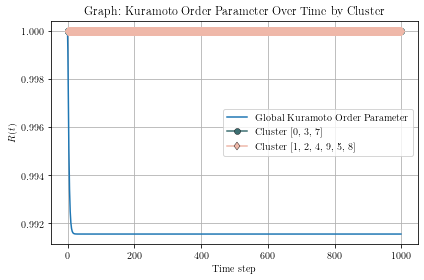

In [14]:
markers = ['o', "d","v",'.', '.']
cluster_colors = [
'#3c6e71',#c1
'#efb8a9',#c7
'#adc178',#c6
'black',
'blue'
]


# Plot the Kuramoto order parameter over time for each cluster and global
plt.figure(figsize=(6, 4))
#plt.figure(figsize=(1770 / 300, 1170 / 300), dpi=300)

arrays = theta_history[:,]
R_tot = kuramoto_order_parameter_over_time(arrays)
plt.plot(R_tot, label='Global Kuramoto Order Parameter')
print(f'Global parameter: {np.sum(R_tot) / repetition}')


for i,cluster in enumerate(c):
    arrays = theta_history[:,[i for i in cluster]]
    R = kuramoto_order_parameter_over_time(arrays)
    print(f'Cluster {cluster}: {np.sum(R) / repetition}')

    plt.plot(R, marker=markers[i%5], color=cluster_colors[i%5], label=f'Cluster {cluster}')


plt.xlabel('Time step')
plt.ylabel('$R(t)$')
plt.title(f'Graph: Kuramoto Order Parameter Over Time by Cluster')
plt.grid(True)
if num_nontrivial_clusters < 15:
    leg = plt.legend(loc='best', framealpha=0.8)

    for h in leg.legendHandles:  # Avoid overcrowded legends
        h.set_markeredgecolor('black') 
        h.set_markeredgewidth(0.4) 
plt.tight_layout()

#plt.savefig(f'Images/Frustration_results/Order_parameters_time_example_comparison_graph', dpi=300, bbox_inches=None, transparent=True)


Number of non trivial clusters: 2


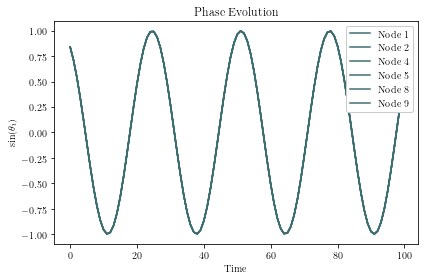

In [15]:
# Plot trajectories results

plt.figure(figsize=(6, 4))

# Markers and colors as in the tikz picture of the paper
markers = ['o', '*', "v", "^", "d", "s", "p"]
colors = [
'#3c6e71',#c1
'#3c6e71',#c1
'#3c6e71',#c1
'#3c6e71',#c1
'#3c6e71',#c1
'#3c6e71',#c1
'#efb8a9',#c7
'#efb8a9',#c7
'#bc4749',#c5
'#bc4749',#c5
'#a8dadc',#c2
'#e9c46a',#c3
'#a3a6c2',#c4
'#adc178',#c6
]


# CLusters with more than one nodes
c = [e for e in clusters if len(e) > 1]
print(f'Number of non trivial clusters: {len(c)}')

for idx, i in enumerate([1,2,4,5,8,9]):#range(2):#range(N) c[0]
    plt.plot(times[0:100], np.sin(theta_history[0:100,i]), label=f'Node {i}', color = colors[idx])
plt.xlabel('Time')
plt.ylabel(r'$\sin(\theta_i$)')
plt.title('Phase Evolution')
#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.legend(loc='upper right', framealpha=1)
plt.tight_layout()

#plt.savefig(f'Images/Frustration_results/Phase_evolution_time_example_comparison_graph', dpi=300, bbox_inches=None, transparent=True)